# Setup

In [58]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [59]:
# Parameters
model_to_use = 'rf-3part' # "pymer" or "rf" or "rf-pca" or "xgboost-3part" or "rf-3part"
no_increase = True
pct_overlap_cutoff = 0.8

aoh = True # plot extinction probabilities or just changes in AOH?
curve_type = 'power_law' # either "power_law" or "gompertz"

save_plots = False

#  fiddling with model name
model_to_use = model_to_use + ('_no-increase' if no_increase else '')

# Taxonomic & body mass summaries

In [60]:
# The Shapley style value for partialling the effects of hunting and habitat loss
def shapley_ish_value(hum_abs, interest, other, joint):
    return (1 / 2) * ((interest - hum_abs) + (joint - other))

In [61]:
# Defining the AOH-extinction risk curve
def aoh_extinction_curve(aoh_hum_abs, aoh_new, curve_type = 'power_law', z = 0.25, a = 2.5, b = -14.5, alpha = 1):
    assert curve_type in ['power_law', 'gompertz'], f'Curve type "{curve_type}" not supported'
    
    if curve_type == 'power_law':
        prob_extinction = 1 - ((aoh_new / aoh_hum_abs) ** z)
    elif curve_type == 'gompertz':
        prob_extinction = 1 - (np.exp(-1 * np.exp(a + b * ((aoh_new / aoh_hum_abs) ** alpha))))

    #  clip values to 0-1 range so they're probabilities
    prob_extinction = np.clip(prob_extinction, a_min = 0, a_max = 1)

    return prob_extinction

In [62]:
# Read in effective AOH results
aoh_info_fp = f'/Users/emiliolr/Desktop/new_hunting_results/effective_aoh_info_{model_to_use}.csv'
aoh_info = pd.read_csv(aoh_info_fp)

In [63]:
# Read in taxonomic + body mass info for tropical mammal species
tropical_mammals_fp = '/Users/emiliolr/Google Drive/My Drive/LIFE/datasets/derived_datasets/tropical_species/tropical_mammals_taxonomic_info_w_body_mass_iucn2025.csv'
tropical_mammals = pd.read_csv(tropical_mammals_fp)

#  join on tropical mammal info w/effective AOH results
aoh_info = pd.merge(aoh_info, tropical_mammals, how = 'left', left_on = 'species', right_on = 'iucn_id')
aoh_info = aoh_info.drop(columns = ['iucn_id', 'synonyms', 'is_species', 'combine_match_species', 
                                    'combine_bm_match_level'])

In [64]:
# Read in percent overlap w/tropical forest zone info (just current AOH overlap)
aoh_pct_overlap_fp = '/Users/emiliolr/Desktop/new_hunting_results/tropical_mammals_aoh_overlap.csv'
aoh_pct_overlap = pd.read_csv(aoh_pct_overlap_fp)
aoh_pct_overlap = aoh_pct_overlap.rename(columns = {'aoh_pct_overlap' : 'aoh_pct_overlap_current'})

#  join on percent overlap info w/effective AOH results
aoh_info = pd.merge(aoh_info, aoh_pct_overlap, how = 'left', left_on = 'species', right_on = 'iucn_id')
aoh_info = aoh_info.drop(columns = ['iucn_id'])

#  filter species by percent overlap cutoff
aoh_info = aoh_info[aoh_info['aoh_pct_overlap_current'] >= pct_overlap_cutoff]

In [65]:
# Adding columns to represent AOH percent changes: negative if AOH loss, positive if gain
aoh_info['hunting_aoh_partial'] = shapley_ish_value(aoh_info['human_absent_aoh_total'],
                                                    aoh_info['human_absent_aoh_w_hunting_total'],
                                                    aoh_info['current_aoh_total'],
                                                    aoh_info['current_aoh_w_hunting_total'])
aoh_info['hunting_aoh_partial'] = (aoh_info['hunting_aoh_partial'] / aoh_info['human_absent_aoh_total'])

aoh_info['land_cover_aoh_partial'] = shapley_ish_value(aoh_info['human_absent_aoh_total'],
                                                       aoh_info['current_aoh_total'],
                                                       aoh_info['human_absent_aoh_w_hunting_total'],
                                                       aoh_info['current_aoh_w_hunting_total'])
aoh_info['land_cover_aoh_partial'] = (aoh_info['land_cover_aoh_partial'] / aoh_info['human_absent_aoh_total'])

aoh_info['combined_aoh'] = (aoh_info['current_aoh_w_hunting_total'] / aoh_info['human_absent_aoh_total']) - 1

In [66]:
# Checking the median effects over all species
aoh_info[['hunting_aoh_partial', 'land_cover_aoh_partial', 'combined_aoh']].median()

hunting_aoh_partial      -0.106230
land_cover_aoh_partial   -0.204549
combined_aoh             -0.377110
dtype: float64

In [67]:
# Adding extinction probability columns for each of the four scenarios
aoh_info['human_absent_extinction'] = aoh_extinction_curve(aoh_info['human_absent_aoh_total'], 
                                                           aoh_info['human_absent_aoh_total'])
aoh_info['current_extinction'] = aoh_extinction_curve(aoh_info['human_absent_aoh_total'], 
                                                      aoh_info['current_aoh_total'])
aoh_info['human_absent_w_hunting_extinction'] = aoh_extinction_curve(aoh_info['human_absent_aoh_total'], 
                                                                     aoh_info['human_absent_aoh_w_hunting_total'])
aoh_info['current_w_hunting_extinction'] = aoh_extinction_curve(aoh_info['human_absent_aoh_total'], 
                                                                aoh_info['current_aoh_w_hunting_total'])

#  partialling the joint extinction scores
aoh_info['hunting_ext_partial'] = shapley_ish_value(aoh_info['human_absent_extinction'],
                                                    aoh_info['human_absent_w_hunting_extinction'],
                                                    aoh_info['current_extinction'],
                                                    aoh_info['current_w_hunting_extinction'])
aoh_info['land_cover_ext_partial'] = shapley_ish_value(aoh_info['human_absent_extinction'],
                                                       aoh_info['current_extinction'],
                                                       aoh_info['human_absent_w_hunting_extinction'],
                                                       aoh_info['current_w_hunting_extinction'])
aoh_info['combined_ext'] = (aoh_info['current_w_hunting_extinction'] - aoh_info['human_absent_extinction'])

In [68]:
# Adding a column for body mass category (matching the def from Gallego-Zamorano)
def bm_cats(bm):
    if bm < 0.1:
        return 'very small'
    elif (bm >= 0.1) and (bm < 1):
        return 'small'
    elif (bm >= 1) and (bm < 10):
        return 'medium'
    else:
        return 'large'

aoh_info['body_mass_cat'] = (aoh_info['combine_body_mass'] / 1000).apply(bm_cats)
cat_counts = aoh_info['body_mass_cat'].value_counts()

In [69]:
# Removing a few CRAZY outliers w/huge gains due to contemporary habitat change
aoh_info = aoh_info[aoh_info['land_cover_aoh_partial'] < 10]

In [70]:
# Pivoting into a long format to make plotting easier
if aoh:
    value_vars = ['land_cover_aoh_partial', 'hunting_aoh_partial', 'combined_aoh']
    id_vars = [c for c in aoh_info.columns if (c not in value_vars) and ('ext' not in c)]

    aoh_info_long = aoh_info.melt(id_vars = id_vars, value_vars = value_vars, var_name = 'aoh_loss_type', 
                                  value_name = 'aoh_loss_amt')
else:
    value_vars = ['land_cover_ext_partial', 'hunting_ext_partial', 'combined_ext']
    id_vars = [c for c in aoh_info.columns if (c not in value_vars) and ('aoh' not in c)]

    aoh_info_long = aoh_info.melt(id_vars = id_vars, value_vars = value_vars, var_name = 'ext_type', 
                                  value_name = 'ext_change_amt')

In [71]:
# Renaming for plotting
loss_type_titles = {'land_cover_aoh_partial' : 'Land-Cover (partial)', 
                    'land_cover_ext_partial' : 'Land-Cover (Partial)',
                    'hunting_aoh_partial' : 'Hunting (partial)', 
                    'hunting_ext_partial' : 'Hunting (Partial)',
                    'combined_aoh' : 'Combined', 
                    'combined_ext' : 'Combined'}

col = 'aoh_loss_type' if aoh else 'ext_type'
aoh_info_long[col] = aoh_info_long[col].replace(loss_type_titles)

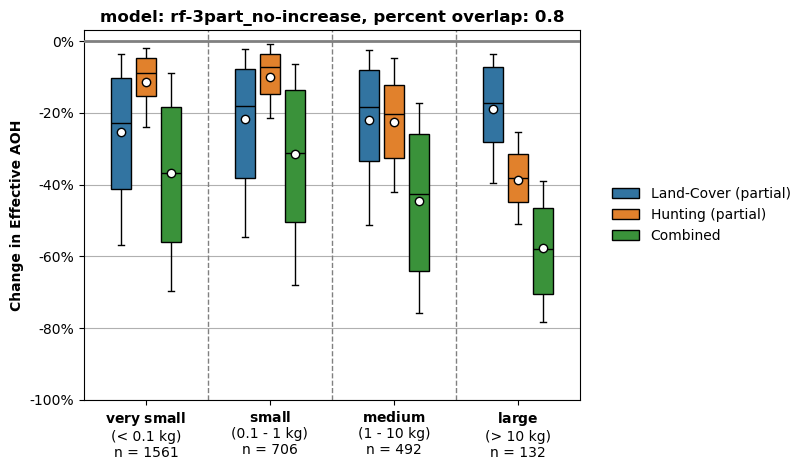

In [73]:
# Plotting effective AOHs by body mass category
bm_cat_order = ['very small', 'small', 'medium', 'large']
y = 'aoh_loss_amt' if aoh else 'ext_change_amt'
hue = 'aoh_loss_type' if aoh else 'ext_type'

sns.boxplot(data = aoh_info_long, x = 'body_mass_cat', y = y, hue = hue, order = bm_cat_order, showfliers = False, whis = (10, 90), 
            width = 0.6, gap = 0.2, capwidths = 0.05, notch = False, linecolor = 'black', showmeans = True, 
            meanprops = {'markeredgecolor' : 'black', 'marker' : 'o', 'markerfacecolor' : 'white'}, zorder = 100)

#  adding line for no AOH change
plt.axhline(0, color = 'grey', linewidth = 2, zorder = 10)

for i in [0.5, 1.5, 2.5]:
    plt.axvline(i, color = 'grey', linewidth = 1, linestyle = '--')

#  labeling axes + title
plt.xlabel(None)
plt.ylabel(f'Change in {"Effective AOH" if aoh else "Prob. of Extinction"}', weight = 'bold')

#  fiddling w/tick formatting
if aoh:
    yticks = np.arange(-1, 0.2, 0.2) if ('3part' not in model_to_use) or ('no-increase' in model_to_use) else np.arange(-1, 0.8, 0.2)
    ytick_labels = [f'{round(float(i))}%' for i in yticks * 100]
    plt.yticks(ticks = yticks, labels = ytick_labels)

xtick_labels = [r'$\bf{very\ small}$' + f'\n(< 0.1 kg)\nn = {cat_counts.loc["very small"]}', 
                r'$\bf{small}$' + f'\n(0.1 - 1 kg)\nn = {cat_counts.loc["small"]}', 
                r'$\bf{medium}$' + f'\n(1 - 10 kg)\nn = {cat_counts.loc["medium"]}',
                r'$\bf{large}$' + f'\n(> 10 kg)\nn = {cat_counts.loc["large"]}']
plt.xticks(ticks = [0, 1, 2, 3], labels = xtick_labels)

#  fixing the legend
plt.legend(loc = 'center right', bbox_to_anchor = (1.45, 0.5), frameon = False)

#  adding major gridlines
plt.grid(visible = True, which = 'major', axis = 'y')

#  adding a title, just to remind of the model + percent overlap used
if not save_plots:
    plt.title(f'model: {model_to_use}, percent overlap: {pct_overlap_cutoff}', weight = 'bold')

#  optionally saving plot
if save_plots:
    plt.savefig(f'/Users/emiliolr/Desktop/{model_to_use}_{"aoh" if aoh else "ext"}_diff_cutoff={pct_overlap_cutoff}.png', 
                bbox_inches = 'tight', dpi = 400)

plt.show()

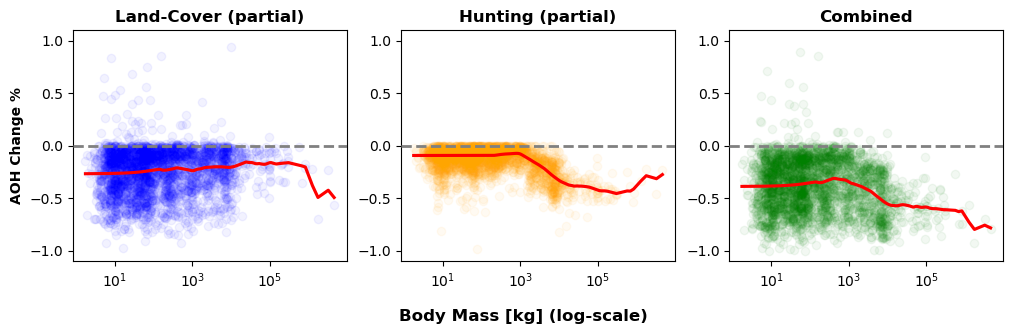

In [74]:
# Looking at the overall relationship between body mass and AOH change for the partial/joint effects
data_sub = aoh_info_long[aoh_info_long[y] <= 1]

fig, axs = plt.subplots(ncols = 3, figsize = (12, 3))

loss_types = data_sub[col].unique()
colors = ['blue', 'orange', 'green']

for i in range(len(axs)):
    axs[i].set(xscale = "log")
    axs[i].axhline(0, color = 'grey', linestyle = '--', linewidth = 2, zorder = 10)

    sub = data_sub[data_sub[col] == loss_types[i]]
    sns.regplot(data = sub, x = 'combine_body_mass', y = y, lowess = True,
                scatter_kws = {'color' : colors[i], 'alpha' : 0.05}, line_kws = {'color' : 'red'}, ax = axs[i])

    axs[i].set_ylim(-1.1 if aoh else -0.1, 1.1)
    axs[i].set_title(loss_types[i], weight = 'bold')
    axs[i].set_xlabel('')

    if i != 0:
        axs[i].set_ylabel('')
    else:
        axs[i].set_ylabel('AOH Change %' if aoh else 'Extinction Prob. Change', weight = 'bold')

fig.supxlabel('Body Mass [kg] (log-scale)', weight = 'bold', y = -0.1)
plt.show()

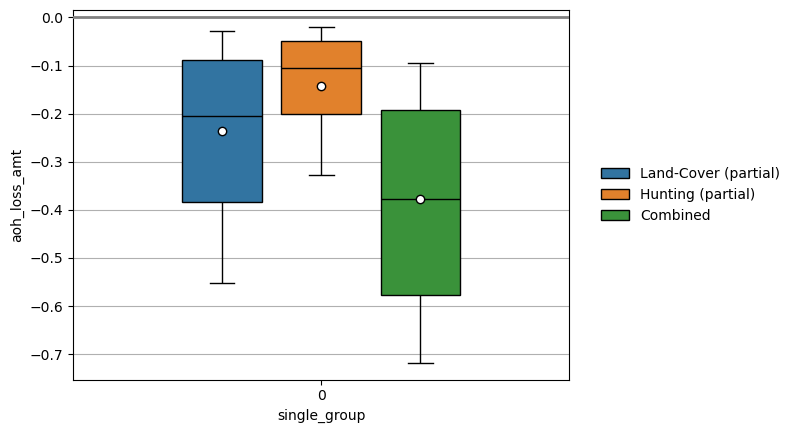

In [75]:
# Just a quick and dirty plot to show the distribution over all samples, not grouped by BM category
aoh_info_long['single_group'] = 0

sns.boxplot(data = aoh_info_long, x = 'single_group', y = y, hue = hue, showfliers = False, whis = (10, 90), 
            width = 0.6, gap = 0.2, capwidths = 0.05, notch = False, linecolor = 'black', showmeans = True, 
            meanprops = {'markeredgecolor' : 'black', 'marker' : 'o', 'markerfacecolor' : 'white'}, zorder = 100)
plt.grid(visible = True, which = 'major', axis = 'y')

plt.axhline(0, color = 'grey', linewidth = 2, zorder = 10)
plt.legend(loc = 'center right', bbox_to_anchor = (1.45, 0.5), frameon = False)

plt.show()

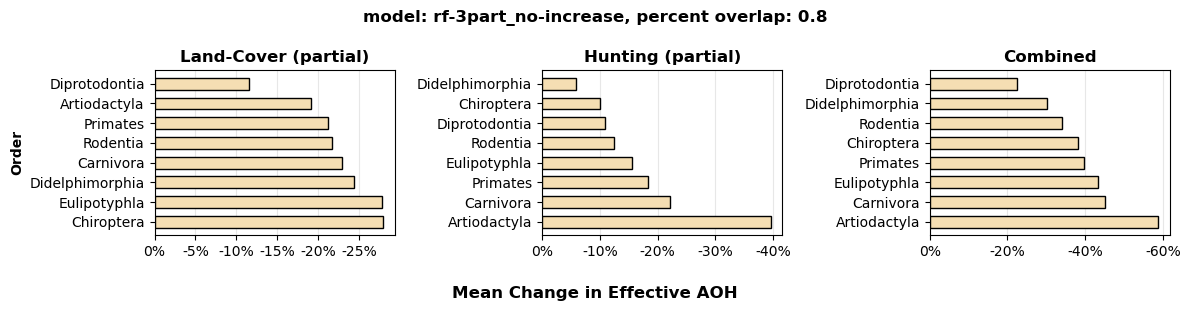

In [57]:
# Taxonomic summaries of change in effective AOH
tax_level = 'order'
tax_n_thresh = 50

facet = 'aoh_loss_type' if aoh else 'ext_type'
x = 'aoh_loss_amt' if aoh else 'ext_change_amt'

fig, axs = plt.subplots(1, 3, figsize = (12, 3))

for i, loss_type in enumerate(list(aoh_info_long[facet].unique())):
    #  filtering out underrepresented tax levels
    tax_to_keep = aoh_info_long[tax_level].value_counts() / 3
    tax_to_keep = tax_to_keep[tax_to_keep > tax_n_thresh].index.to_list()
    
    aoh_info_grouped = aoh_info_long[aoh_info_long[tax_level].isin(tax_to_keep)]
    
    #  grouping + extracting mean effect
    aoh_info_grouped = aoh_info_grouped[aoh_info_grouped[facet] == loss_type].groupby([tax_level])
    
    mean_aoh_effect = aoh_info_grouped[x].mean().sort_values()
    mean_aoh_effect = mean_aoh_effect.to_frame().reset_index()
    mean_aoh_effect[tax_level] = mean_aoh_effect[tax_level].str.title()
    
    #  plotting in barplot format
    axs[i].barh(mean_aoh_effect[tax_level], mean_aoh_effect[x] * (-1 if aoh else 1), color = 'wheat', 
                edgecolor = 'black', height = 0.6, zorder = 10)
    axs[i].grid(visible = True, which = 'major', axis = 'x', alpha = 0.3, zorder = 0)
    
    if i == 0:
        axs[i].set_ylabel(str(tax_level).title(), weight = 'bold')
    axs[i].set_title(loss_type, weight = 'bold')
    
    xticks = axs[i].get_xticks()
    xlim = axs[i].get_xlim()
    if aoh:
        axs[i].set_xticks(xticks, [f'{"-" if x > 0 else ("+" if x < 0 else "")}{abs(int(x * 100))}%' for x in xticks])
    else:
        axs[i].set_xticks(xticks, [f'{"+" if x > 0 else ("-" if x < 0 else "")}{round(x, 2)}' for x in xticks])
    axs[i].set_xlim(xlim)

# labeling
fig.supxlabel(f'Mean Change in {"Effective AOH" if aoh else "Prob. of Extinction"}', weight = 'bold')
if not save_plots:
    plt.suptitle(f'model: {model_to_use}, percent overlap: {pct_overlap_cutoff}', weight = 'bold')

fig.tight_layout()

if save_plots:
    plt.savefig(f'/Users/emiliolr/Desktop/{model_to_use}_tax_breakdown_partial_w_joint_{"aoh" if aoh else "ext"}.png', 
                bbox_inches = 'tight', dpi = 400)

## Figuring out extinction risk

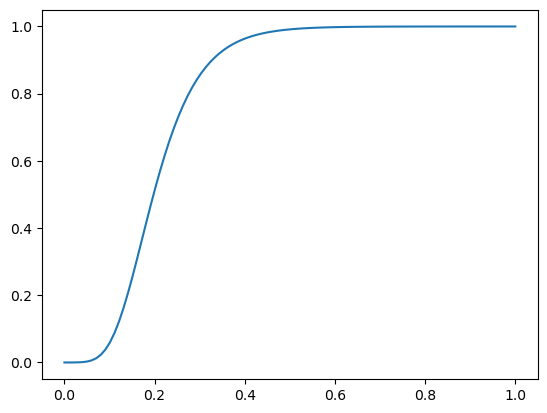

In [117]:
# Sense-checking the curve shape
aoh_hum_abs = 10
aoh_new = np.linspace(0, 10, 100)
extinction_risk = aoh_extinction_curve(aoh_hum_abs, aoh_new, curve_type = 'gompertz')

plt.plot(aoh_new / aoh_hum_abs, 1 - extinction_risk)
plt.show()

## Checking proportions

In [76]:
t = (aoh_info['hunting_aoh_partial'] < aoh_info['land_cover_aoh_partial']).astype(int)
t = t.to_frame(name = 'hunting_greater_impact')

t['bm_cat'] = aoh_info['body_mass_cat']
t.groupby('bm_cat').mean()

,hunting_greater_impact
bm_cat,
large,0.840909
medium,0.571138
small,0.259207
very small,0.230424


In [77]:
t['hunting_greater_impact'].mean()

0.3234072022160665

# Proof of concept for $\Delta$AOH

In [471]:
import rioxarray as rxr

In [477]:
# CURRENT AOH
ex_cur_aoh_fp = "/Users/emiliolr/Desktop/phd-exploratory-work/data/elephants/7140_RESIDENT.tif"
ex_cur_aoh = rxr.open_rasterio(ex_cur_aoh_fp)

# HUMAN-ABSENT AOH
ex_prev_aoh_fp = "/Users/emiliolr/Desktop/phd-exploratory-work/data/elephants/human_absent/7140_RESIDENT.tif"
ex_prev_aoh = rxr.open_rasterio(ex_prev_aoh_fp)

# HUNTING PRESSURE MAP
ex_hp_fp = "/Users/emiliolr/Desktop/hunting_testing/current/7140_hunting_pred_pymer.tif"
ex_hp = rxr.open_rasterio(ex_hp_fp)

In [478]:
# TOTAL HUMAN-ABSENT AOH
prev_aoh_tot = float(ex_prev_aoh.sum())

# COMBINED: HP + HL
ex_hp = ex_hp.rio.reproject_match(ex_cur_aoh)

no_pred_mask = ((ex_cur_aoh != 0) & (xr.ufuncs.isnan(ex_hp)))
ex_hp = ex_hp.where(~no_pred_mask, other = 1)

effective_aoh = ex_cur_aoh * ex_hp

In [479]:
# FINAL PRODUCT
effective_aoh = effective_aoh.rio.reproject_match(ex_prev_aoh).fillna(0)
delta_aoh_tot = effective_aoh - ex_prev_aoh
delta_aoh_tot_pct = (delta_aoh_tot.where(ex_prev_aoh != 0) / ex_prev_aoh) # | (ex_cur_aoh != 0)

In [490]:
float(effective_aoh.min()) 

False

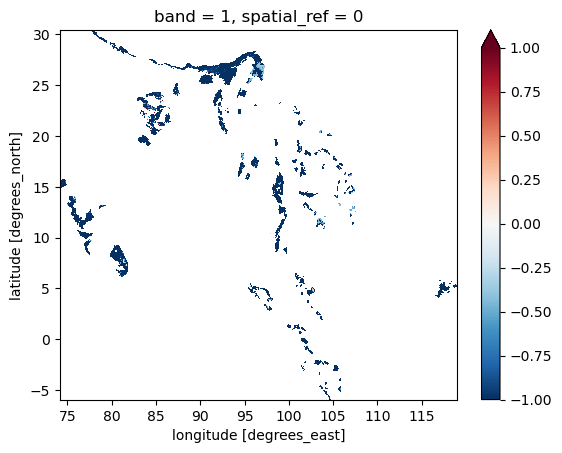

In [482]:
delta_aoh_tot_pct.squeeze().plot.pcolormesh(vmin = -1, vmax = 1, center = 0, cmap = 'RdBu_r');

In [483]:
# TEMPLATE INTERACTION
template_raster_cell_area = rxr.open_rasterio("/Users/emiliolr/Desktop/template_raster_cell_area.tif")
delta_aoh_tot_pct = delta_aoh_tot_pct.rio.reproject_match(template_raster_cell_area)
delta_aoh_tot_pct_per_km2 = delta_aoh_tot_pct / template_raster_cell_area

In [486]:
delta_aoh_tot_pct_per_km2.min()

<xarray.DataArray ()> Size: 4B
array(-0.33794916, dtype=float32)
Coordinates:
    spatial_ref  int64 8B 0

In [492]:
template_raster_cell_area.max()

<xarray.DataArray ()> Size: 4B
array(3.4191866, dtype=float32)
Coordinates:
    spatial_ref  int64 8B 0